# Get some data in

## Set libraries

In [1]:
import numpy as np
import xarray as xr
import rasterio
%matplotlib inline
from matplotlib.pyplot import *
from glob import glob
import glob
import os
import datetime
import pandas as pd
from rasterio_to_xarray import rasterio_to_xarray, xarray_to_rasterio

## Function to read in the MAIAC files into a data array

In [2]:
def maiac_file_to_da(filename):
    da = rasterio_to_xarray(filename)
    
    time_str = os.path.basename(filename)[17:-13]
    time_obj = datetime.datetime.strptime(time_str, '%Y%j%H%M')
    da.coords['time'] = time_obj
    
    return da

In [ ]:
# get a list of files
files = glob(r'D:\MAIAC_Data\Europe\h00v01\Projected\2011\*_proj.tif')
# Map runs function on every element of a list... creating a list of 2D arrays (the date)
list_of_das = map(maiac_file_to_da, files)
# Make the dataset 3D over the dimension time
MAIAC_AOT = xr.concat(list_of_das, 'time')
# Reorder time- because the A and T mess the time variable up and resampling wont work otherwise
reordered_MAIAC_AOT = MAIAC_AOT.isel(time=np.argsort(MAIAC_AOT.time))
# Get AOT values for all of the years for Chilbolton pixel from MAIAC data
Measurements = reordered_MAIAC_AOT.isel(x=1103, y=1027).dropna('time').to_dataframe(name='MAIAC_AOT')
Measurements.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AERONET\Test\2011.csv')

# Put all in loop so it goes through each folder and produces the csv file

In [7]:
folders = glob.glob(r'D:\MAIAC_Data\Europe\h00v01\Projected\20*')

In [8]:
for folder in folders:
    files = glob.glob(r'{fname}\*_proj.tif'.format(fname=folder))
    list_of_das = map(maiac_file_to_da, files)
    MAIAC_AOT = xr.concat(list_of_das, 'time')
    MAIAC_AOT.attrs.clear()
    reordered_MAIAC_AOT = MAIAC_AOT.isel(time=np.argsort(MAIAC_AOT.time))
    Measurements = reordered_MAIAC_AOT.isel(x=1103, y=1027).dropna('time').to_dataframe(name='MAIAC_AOT')
    Measurements.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AERONET\Test\Alldata.csv', mode='a')
    print('Processed {fname}'.format(fname=folder))

Processed D:\MAIAC_Data\Europe\h00v01\Projected\2007


In [2]:
MAIAC_Chil = pd.read_csv(r'D:\Annies_Dissertation\Methodology\Validation\AERONET\Test\Alldata_FINAL.csv')

In [10]:
MAIAC_Chil[:10]

,Time,x,y,AOT,AOT_New,timestamp
timestamp,,,,,,
2000-02-25 10:50:00,25/02/2000 10:50,138808.1057,438327.3471,83,0.083,2000-02-25 10:50:00
2000-02-26 11:35:00,26/02/2000 11:35,138808.1057,438327.3471,164,0.164,2000-02-26 11:35:00
2000-03-12 12:30:00,12/03/2000 12:30,138808.1057,438327.3471,205,0.205,2000-03-12 12:30:00
2000-03-15 11:25:00,15/03/2000 11:25,138808.1057,438327.3471,186,0.186,2000-03-15 11:25:00
2000-03-22 11:30:00,22/03/2000 11:30,138808.1057,438327.3471,591,0.591,2000-03-22 11:30:00
2000-04-06 10:45:00,06/04/2000 10:45,138808.1057,438327.3471,331,0.331,2000-04-06 10:45:00
2000-04-07 11:30:00,07/04/2000 11:30,138808.1057,438327.3471,210,0.210,2000-04-07 11:30:00
2000-04-08 10:35:00,08/04/2000 10:35,138808.1057,438327.3471,311,0.311,2000-04-08 10:35:00
2000-04-08 12:15:00,08/04/2000 12:15,138808.1057,438327.3471,319,0.319,2000-04-08 12:15:00


In [4]:
MAIAC_Chil['timestamp'] = pd.to_datetime(MAIAC_Chil.Time, format='%d/%m/%Y %H:%M')

In [5]:
MAIAC_Chil = MAIAC_Chil.set_index('timestamp')

In [6]:
MAIAC_Chil['AOT_New']= MAIAC_Chil.AOT/1000

In [7]:
MAIAC_Chil['timestamp'] = MAIAC_Chil.index

In [8]:
MAIAC_Chil = MAIAC_Chil.drop_duplicates(subset='timestamp')

In [9]:
MAIAC_Chil = MAIAC_Chil.sort_index()

# Read in AERONET data file into pandas DataFrame

In [11]:
import pandas as pd

In [12]:
def read_aeronet(filename):
    """Read a given AERONET AOT data file, and return it as a dataframe.
    
    This returns a DataFrame containing the AERONET data, with the index
    set to the timestamp of the AERONET observations. Rows or columns
    consisting entirely of missing data are removed. All other columns
    are left as-is.
    """
    dateparse = lambda x: pd.datetime.strptime(x, "%d:%m:%Y %H:%M:%S")
    aeronet = pd.read_csv(filename, skiprows=4, na_values=['N/A'],
                          parse_dates={'times':[0,1]},
                          date_parser=dateparse)

    aeronet = aeronet.set_index('times')
    del aeronet['Julian_Day']
    
    # Drop any rows that are all NaN and any cols that are all NaN
    # & then sort by the index
    an = (aeronet.dropna(axis=1, how='all')
                .dropna(axis=0, how='all')
                .rename(columns={'Last_Processing_Date(dd/mm/yyyy)': 'Last_Processing_Date'})
                .sort_index())

    return an

In [13]:
Aeronet = read_aeronet(r'D:\Annies_Dissertation\Methodology\Validation\AERONET\All_data050101_161231_Chilbolton.lev20')

In [14]:
Aeronet[:10]

,AOT_1640,AOT_1020,AOT_870,AOT_675,AOT_500,AOT_440,AOT_380,AOT_340,Water(cm),%TripletVar_1640,...,%TripletVar_440,%TripletVar_380,%TripletVar_340,440-870Angstrom,380-500Angstrom,440-675Angstrom,500-870Angstrom,340-440Angstrom,Last_Processing_Date,Solar_Zenith_Angle
times,,,,,,,,,,,,,,,,,,,,,
2005-10-10 12:38:46,NaN,0.079535,0.090636,0.143492,0.246959,0.301443,0.373063,0.430350,2.115728,NaN,...,0.196419,0.181772,0.532137,1.776185,1.495202,1.757222,1.808187,1.368259,17/10/2006,58.758553
2005-10-10 12:53:45,NaN,0.076091,0.088152,0.142735,0.250090,0.306848,0.381753,0.442439,2.151210,NaN,...,0.268519,0.575421,0.669254,1.842931,1.532986,1.812417,1.880650,1.406191,17/10/2006,59.391479
2005-10-10 12:59:46,NaN,0.080473,0.092602,0.148098,0.258315,0.316427,0.393984,0.456950,2.158919,NaN,...,0.207976,0.198821,0.368519,1.816853,1.530241,1.797861,1.850624,1.412028,17/10/2006,59.692552
2005-10-10 13:08:45,NaN,0.078049,0.090091,0.145124,0.252962,0.309554,0.385898,0.447138,2.045271,NaN,...,0.259162,0.420704,0.170024,1.824157,1.531183,1.794243,1.862053,1.413390,17/10/2006,60.190763
2005-10-10 13:23:46,NaN,0.077520,0.090136,0.145518,0.255085,0.313247,0.390174,0.452175,1.993235,NaN,...,0.465213,0.445026,0.148857,1.840785,1.540410,1.815273,1.876348,1.410697,17/10/2006,61.149727
2005-10-10 13:38:45,NaN,0.079958,0.094025,0.152432,0.268651,0.330463,0.413113,0.478949,1.901130,NaN,...,0.208010,0.193379,0.396386,1.857612,1.559833,1.832172,1.893654,1.426591,17/10/2006,62.256730
2005-10-10 13:53:45,NaN,0.080028,0.094143,0.152165,0.268086,0.329825,0.412917,0.479721,1.880605,NaN,...,0.656559,0.769271,0.795513,1.853189,1.565855,1.831613,1.887726,1.439973,17/10/2006,63.506309
2005-10-10 14:23:45,NaN,0.094797,0.109809,0.167836,0.284558,0.346456,0.428425,0.493930,1.868666,NaN,...,0.695588,0.652941,0.543619,1.700525,1.483255,1.714417,1.718805,1.362961,17/10/2006,66.391970
2005-10-10 15:05:06,NaN,0.100339,0.117901,0.179424,0.301536,0.365371,0.450319,0.515718,1.969662,NaN,...,0.511912,0.196935,0.279000,1.674118,1.454016,1.682888,1.694920,1.325517,17/10/2006,71.092634


In [15]:
Aeronet = Aeronet[['AOT_440']].dropna()

In [16]:
Aeronet = Aeronet.sort_index()

In [17]:
indexed = MAIAC_Chil.reindex(Aeronet.index, method='nearest', tolerance='10Min').dropna()

In [18]:
result = pd.merge(Aeronet, indexed, left_index=True, right_index=True).reset_index().rename(columns={'times':'AERONET_Time', 
                                                                                                        'timestamp':'MAIAC_Time', 
                                                                                                     'AOT_New':'MAIAC_AOT', 'AOT_440':'AERONET_AOT'})

In [19]:
result = result[['MAIAC_Time', 'AERONET_Time', 'AERONET_AOT', 'MAIAC_AOT']].dropna()

In [20]:
result[:10]

,MAIAC_Time,AERONET_Time,AERONET_AOT,MAIAC_AOT
0,2005-10-10 13:25:00,2005-10-10 13:23:46,0.313247,0.226
1,2005-10-15 11:55:00,2005-10-15 11:52:30,0.332912,0.236
2,2005-10-15 13:40:00,2005-10-15 13:37:31,0.212158,0.129
3,2005-10-27 12:30:00,2005-10-27 12:35:31,0.115170,0.067
4,2005-11-01 11:00:00,2005-11-01 10:56:13,0.041254,0.088
5,2005-11-01 11:00:00,2005-11-01 11:05:12,0.041550,0.088
6,2005-11-01 12:45:00,2005-11-01 12:35:14,0.038766,0.039
7,2005-11-01 12:45:00,2005-11-01 12:50:14,0.035431,0.039
8,2005-11-04 11:30:00,2005-11-04 11:20:13,0.070735,0.061
9,2005-11-04 11:30:00,2005-11-04 11:35:13,0.075269,0.061


In [21]:
result = result.set_index('MAIAC_Time')

In [22]:
result.isnull().sum()

AERONET_Time    0
AERONET_AOT     0
MAIAC_AOT       0
dtype: int64

In [55]:
%matplotlib inline

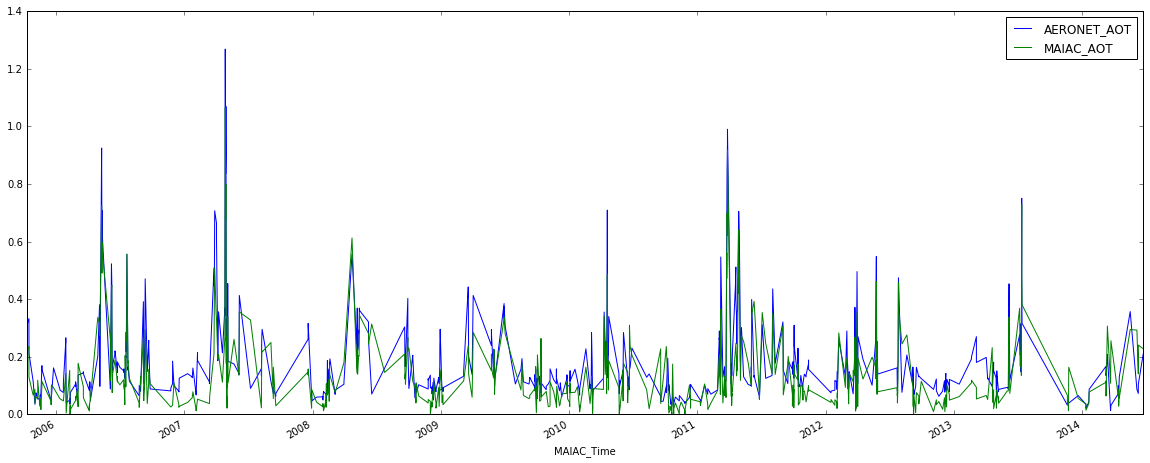

In [56]:
result.plot(figsize=(20, 8))
savefig(r'D:\Annies_Dissertation\Analysis\Chil_validation_graph.jpeg')

In [57]:
result['error'] = result['AERONET_AOT'] - result['MAIAC_AOT']

In [58]:
result.error.abs().describe()

count    869.000000
mean       0.067193
std        0.051317
min        0.000234
25%        0.030522
50%        0.058529
75%        0.089954
max        0.331584
Name: error, dtype: float64

In [59]:
(result.error > 20).sum()

0

In [60]:
len(result)

869

In [65]:
result.MAIAC_AOT.describe()

count    869.000000
mean       0.128092
std        0.135128
min        0.000000
25%        0.043000
50%        0.082000
75%        0.164000
max        1.066000
Name: MAIAC_AOT, dtype: float64

In [66]:
result.AERONET_AOT.describe()

count    869.000000
mean       0.177500
std        0.154765
min        0.013683
25%        0.087325
50%        0.129031
75%        0.202441
max        1.268825
Name: AERONET_AOT, dtype: float64

In [67]:
result.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AERONET\Chil_validation.csv')

In [69]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_true = result.AERONET_AOT, y_pred = result.MAIAC_AOT))
rmse

0.08452970527939516

In [71]:
from sklearn.metrics import mean_absolute_error
me = mean_absolute_error(y_true = result.AERONET_AOT, y_pred = result.MAIAC_AOT)
me

0.06719297583429229

# Regression

In [26]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(result.AERONET_AOT,result.MAIAC_AOT)
print("r-squared:", r_value**2)
print("p-value:", p_value)
print("Slope:", slope)

r-squared: 0.803929721547
p-value: 5.50268726006e-309
Slope: 0.782856479788
